# Sidekick- Combine features

Some tests with multiple features.

In [185]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)
#matplotlib.rcParams['figure.figsize'] = (20,20)
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['legend.fontsize'] = 32
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from sklearn import linear_model

# Ignore divide by zero warning, as they are tackled in average_contribution_extractor
np.seterr(invalid='ignore')


def subsample(t, granularity):
    if granularity > 1.0 or granularity <= 0:
        raise ValueError("granularity must be in ]0, 1]")
    t0 = 0
    n_samples = int(np.ceil(granularity * t))
    if n_samples == 1:
        return [t-1]
    else:
        return np.linspace(t0, t-1, n_samples, dtype=int)
    
    
def mean_increment(money):
    d = np.diff(money)
    increments = [i for i in d if i != 0]
    if len(increments) > 0:
        return np.mean(increments)
    else:
        return 0

    
def average_contribution_extractor(project):
    #if project.backers > 0:
    #    return project.money / project.backers
    #else:
    #    return 0
    return np.nan_to_num(project.money / project.backers)


def log_last_sample(c=1.0):
    return lambda a: np.log(a[-1] + c)
    
    
def augment_feature_matrix(X, projects, time_series, samples, processing):
    X_new = np.array([processing(p.__getattribute__(time_series)[samples]) for p in projects])
    X_new = np.expand_dims(X_new, axis=1)
    X = np.hstack((X, X_new))
    return X

    
def evaluate(X_test, y_test, model):
    se_successful = []
    se_failed = []
    se_total = []
    accuracy = 0
    for i, x_test in enumerate(X_test):
        if normalized:
            goal = 1
        else:
            p = projects_test_filtered[i]
            goal = float(p.goal)
        x_test = np.expand_dims(x_test, axis=0)
        #y_pred = x_test * regr.coef_ + regr.intercept_
        y_pred = model.predict(x_test)
        y_pred = y_pred[0]
        y_actual = y_test[i][0]
        se = (y_pred - y_actual)**2
        se_total.append(se)
        if y_test[i] >= 1.0:  # Project is successful
            se_successful.append(se)
        else:  # project is failed
            se_failed.append(se)
        if normalized:
            if (y_pred >= 1 and y_actual >= 1) or (y_pred < 1 and y_actual < 1):
                accuracy += 1
        else:
            if (y_pred / goal >= 1 and y_actual / goal >= 1) or (y_pred / goal < 1 and y_actual / goal < 1):
                accuracy += 1
        #else:
        #    print("Error:", i)

    rmse_successful = np.sqrt(np.mean(se_successful))
    rmse_failed = np.sqrt(np.mean(se_failed))
    rmse_total = np.sqrt(np.mean(se_total))
    accuracy /= float(len(y_test))

    print("Accuracy: ", accuracy)
    print("RMSE: ", rmse_total)
    print("RMSE successful: ", rmse_successful)
    print("RMSE failed: ", rmse_failed)

## Load data

In [220]:
sk = Sidekick()
sk.load(update=False)
successful = sk.successful()
failed = sk.failed()
projects_train, projects_test = sk.split(threshold=0.7)

Loading data set...
Data loaded.


## Filter out outliers

In [221]:
outlier_threshold = 10000
normalized = False

for p in np.append(projects_train, projects_test):
    p.normalized = normalized

projects_train_filtered = [p for p in projects_train if np.all([(m - outlier_threshold) <= 0 for m in p.money])]
projects_test_filtered = [p for p in projects_test if np.all([(m - outlier_threshold) <= 0 for m in p.money])]

print("Keeping %.2f%% of data" % (len(projects_train_filtered) / len(projects_train) * 100))

Keeping 83.97% of data


## Extract features

List of features at time $t$:

1. Current pledged money: $m_t$
2. Log-current pledged money: $\ln m_t$
3. Number of backers: $b_t$
4. Log-number of backers: $\ln b_t$
5. Average contribution: $\frac{m_t}{b_t}$
6. Log-average contribution: $\ln\frac{m_t}{b_t}$
7. Number of tweets
8. Log-number of tweets
9. Number of tweeting users
10. Log-number of tweeting users
11. Number of retweets
12. Log-number of retweets
13. Number of tweets replies
14. Log-number of tweets replies

In [311]:
t = 25
granularity = 0.01
samples = subsample(t, granularity)
n_samples = 1
T = 999

# Targets
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

# Feature extractors
last_sample = lambda a: a[-1]

# Money-based
time_series = "money"
processing = last_sample

X_train = np.array([processing(p.__getattribute__(time_series)[samples]) for p in projects_train_filtered])
X_test = np.array([processing(p.__getattribute__(time_series)[samples]) for p in projects_test_filtered])
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

processing = log_last_sample(c=1.0)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

# Backers
time_series = "backers"
processing = last_sample

X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

processing = log_last_sample(c=1.0)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

# Average contribution
processing = last_sample
X_train2 = np.array([processing(average_contribution_extractor(p)) for p in projects_train_filtered])
X_test2 = np.array([processing(average_contribution_extractor(p)) for p in projects_test_filtered])
X_train2 = np.expand_dims(X_train2, axis=1)
X_test2 = np.expand_dims(X_test2, axis=1)
#X_train = np.hstack((X_train, X_train2))
#X_test = np.hstack((X_test, X_test2))

processing = log_last_sample(c=1.0)
X_train2 = np.array([processing(average_contribution_extractor(p)) for p in projects_train_filtered])
X_test2 = np.array([processing(average_contribution_extractor(p)) for p in projects_test_filtered])
X_train2 = np.expand_dims(X_train2, axis=1)
X_test2 = np.expand_dims(X_test2, axis=1)
#X_train = np.hstack((X_train, X_train2))
#X_test = np.hstack((X_test, X_test2))

# Number of tweets
time_series = "number_tweets"
processing = last_sample

X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

processing = log_last_sample(c=0.1)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

# Number tweeting users
time_series = "number_tweeting_users"
processing = last_sample

X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

processing = log_last_sample(c=0.1)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

# Number retweets
time_series = "number_retweets"
processing = last_sample

X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

processing = log_last_sample(c=0.1)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

# Number tweets replies
time_series = "number_tweets_replies"
processing = last_sample

X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

processing = log_last_sample(c=0.1)
X_train = augment_feature_matrix(X_train, projects_train_filtered, time_series, samples, processing)
X_test = augment_feature_matrix(X_test, projects_test_filtered, time_series, samples, processing)

[  0 100]


## Evaluate

In [303]:
# Create linear regression object
regr = linear_model.LinearRegression()
#regr = linear_model.Ridge(alpha=0.1)
regr.fit(X_train, y_train)
print("Linear regression:")
print("  w0=%0.2f" % regr.intercept_[0])
for i, w in enumerate(regr.coef_[0]):
    print("  w%d=%0.2f" % (i+1, w))

print("Results at time %s" % t)
evaluate(X_test, y_test, model=regr)

Linear regression:
  w0=459.52
  w1=1.76
  w2=68.52
  w3=-11.16
  w4=723.15
  w5=-6.89
  w6=-269.63
  w7=5.61
  w8=555.50
  w9=0.78
  w10=-112.88
  w11=-0.12
  w12=81.50
Results at time 25
Accuracy:  0.7784699725890855
RMSE:  1769.85834798
RMSE successful:  1841.1101086
RMSE failed:  349.704803483


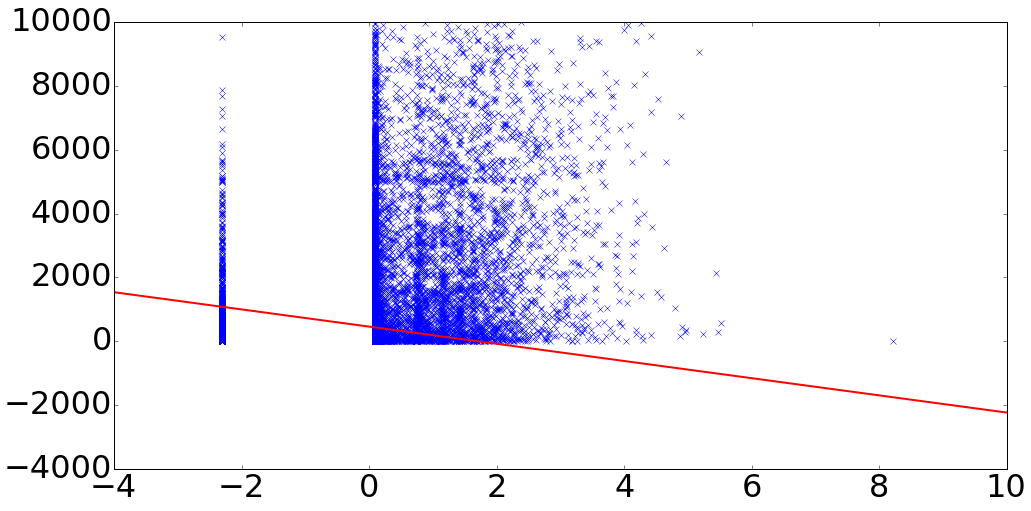

In [309]:
f = 5
plt.plot(X_train[:, f], y_train, 'xb')
x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_[0, f] + regr.intercept_[0]
plt.plot(x, y_pred, 'r-', lw=2)
plt.show()